<a href="https://colab.research.google.com/github/momowade221/Segmentation_Valeur_OM/blob/dev/OM_Segmentation_valeur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CONFIGURATION**

---



In [ ]:
!pip install pyspark
!pip install lifetimes
# !pip install kmodes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=17a48e66688eb741298718664b538f544b36d59d07320e98c36d664820965d5f
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.9 MB/s eta 0:00:00


In [86]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab/Segmentation/
path='/content/drive/MyDrive/Colab/Segmentation/#datasets_OM'

import pyspark
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import *
from pyspark.ml.clustering import *
import datetime as dt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

spark = SparkSession.builder.appName("Transactions_OM").getOrCreate()
spark

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab/Segmentation


# **PRÉPARATION DES DONNÉES**

## **Collection des données**

In [ ]:
#Selection des données sur Hive
""" SELECT * FROM `trusted_om`.`base_transaction_om` WHERE day >= '20230801' AND day <= '20230831'
 ORDER BY RAND() LIMIT 100000; """

In [89]:
df_transaction_om=spark.read.csv(f'{path}/base_transaction_om.csv', header=True)
df_transaction_oem=spark.read.csv(f'{path}/base_transaction_oem.csv', header=True)

#BaseTransaction OM
new_column_names = [col_name.replace("base_transaction_om.", "") for col_name in df_transaction_om.columns]
df_transaction_om= df_transaction_om.toDF(*new_column_names)

#BaseTransaction OEM
new_column_names2 = [col_name2.replace("base_transaction_oem.", "") for col_name2 in df_transaction_oem.columns]
df_transaction_oem= df_transaction_oem.toDF(*new_column_names2)

## **Exploration des données**

---



In [55]:
def df_info(df: DataFrame):

   # Info
    print("\n########### Info ###########")
    df.printSchema()

     # Columns
    print("\n########### Columns ###########")
    print(df.columns)

    # Shape
    print("\n########### Shape ###########")
    num_rows = df.count()
    num_cols = len(df.columns)
    print(f"Number of rows: {num_rows}, Number of columns: {num_cols}")

    # Head
    print("\n########### Head ###########")
    df.show(5, truncate=False)  # Show the first 5 rows without truncation

    # Tail
    print("\n########### Tail ###########")
    df.orderBy(df.columns[0], ascending=False).show(5, truncate=False)  # Show the last 5 rows


    # Quantiles
    print("\n########### Quantiles ###########")
    df.summary().show()

    # NA (Missing values)
    print("\n########### NA (Missing Values) ###########")
    count_NA = df_transaction_om.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in df_transaction_om.columns])
    # Affichez le résultat
    print("Le nombre de colonnes qui contiennent NA ")
    count_NA.show()

    # Compter les occurrences de "NULL" dans chaque colonne
    count_exprs = [expr(f"sum(case when {c} like '%NULL%' then 1 else 0 end) as {c}_count") for c in df_transaction_om.columns]
    print("Le nombre de lignes qui contienent NULL ")
    count_NULL = df_transaction_om.select(*count_exprs)
    count_NULL.show()

    #Duplicate rows
    print("\n########### Données dupliquées ###########")
    duplicate_rows_count = df.groupBy(df.columns).count().filter("count > 1")
    duplicate_rows_count.show()

def printdf(df):
    return df.toPandas()

In [57]:
df_info(df_transaction_om)


########### Info ###########
root
 |-- msisdn: string (nullable = true)
 |-- destinataire: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- date: string (nullable = true)
 |-- description: string (nullable = true)
 |-- fees: string (nullable = true)
 |-- montant: string (nullable = true)
 |-- operation: string (nullable = true)
 |-- status: string (nullable = true)
 |-- statuscode: string (nullable = true)
 |-- titre: string (nullable = true)
 |-- transactionid: string (nullable = true)
 |-- typetransaction: string (nullable = true)
 |-- ingest_date: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)


########### Columns ###########
['msisdn', 'destinataire', 'channel', 'date', 'description', 'fees', 'montant', 'operation', 'status', 'statuscode', 'titre', 'transactionid', 'typetransaction', 'ingest_date', 'year', 'month', 'day']

########### Shape ###########
Number of rows: 1994000

In [58]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import sum

def df_data_info(df: DataFrame):
    # Nombre de clients distincts dans le jeu de données
    customer_count = df.select("msisdn ").distinct().count()
    print("Le nombre de clients dans le jeu de données :", customer_count)
    print("-------------------------------------------------------")

    # Nombre de produits distincts dans le jeu de données
    product_count = df.select("operation").distinct().count()
    print("Le nombre de produits dans le jeu de données :", product_count)
    print("-------------------------------------------------------")

    # Afficher le jeu de données trié par salaire le plus élevé
    print("Notre jeu de données, trié par salaire le plus élevé :")
    df.sort(df["montant"], ascending=False).show(5, truncate=False)
    print("-------------------------------------------------------")

    # Afficher le jeu de données trié par salaire le plus bas
    print("Notre jeu de données, trié par salaire le plus bas :")
    df.sort(df["montant"], ascending=True).show(5, truncate=False)


In [ ]:
print("Channel")
df_transaction_om.select("channel").distinct().show()
print("Type de transaction")
df_transaction_om.select("typetransaction","titre","operation").distinct().orderBy("typetransaction").show(100)
# df_transaction_om.select("typetransaction").distinct().orderBy(asc("typetransaction")).show(100)
# df_transaction_om.select("typetransaction","titre").filter(col("typetransaction")=="C2C").distinct().show(100)
print("Statut")
df_transaction_om.select("status").distinct().show()

Channel
+-------------+
|      channel|
+-------------+
|       mobile|
|         USSD|
|DISTRI_MOBILE|
|         NULL|
+-------------+

Type de transaction
+--------------------+--------------------+--------------------+
|     typetransaction|               titre|           operation|
+--------------------+--------------------+--------------------+
|        ACHAT_CREDIT|     Recharge Credit|            Recharge|
|         Bank2Wallet|      Banque vers OM|         Bank2Wallet|
|                 C2C|           Transfert|           Transfert|
|              CASHIN|               Dépot|               Dépot|
|              CASHIN|               Depot|               Depot|
|              CASHIN|                NULL|              Cashin|
|         CASHINOTHER|                NULL|         Cashinother|
|        CASHIN_OTHER|               Envoi|               Envoi|
|             CASHOUT|    Retrait d'argent|             CASHOUT|
|             CASHOUT|                NULL|             CASHOUT

## **Prétraitement des données**

### Transformation des données

In [90]:
#Transformation en minuscule de la colonne Type transaction
df_transaction_om=df_transaction_om.withColumn("typetransaction", lower(df_transaction_om["typetransaction"]))

#Selection des Colonnes Nécessaires
no_taken_columns=["fees","transactionid","operation", "destinataire","date", "month", "year","ingest_date","description","status","statuscode"]
taken_columns=["msisdn","montant","day" ,"typetransaction", "titre", "channel"]
df_transaction_om=df_transaction_om.select(taken_columns)

# Sélection des colonnes nécessaires et renommage
df_transaction_om = df_transaction_om.select("msisdn", "montant", "day", "typetransaction", "titre", "channel") \
                                     .withColumnRenamed("msisdn", "Numero") \
                                     .withColumnRenamed("day", "Date") \
                                     .withColumnRenamed("typetransaction", "TypeTransaction") \
                                     .withColumnRenamed("montant", "Montant") \
                                     .withColumnRenamed("titre", "TitreTransaction") \
                                     .withColumnRenamed("channel", "Channel")


#Supprimer les lignes où 'Montant' est égal à "NULL"
df_transaction_om = df_transaction_om.filter(df_transaction_om["Montant"] != "NULL")

#Conversion des données des colonnes Date et Montant
df_transaction_om = df_transaction_om.withColumn("Montant", col("Montant").cast(FloatType()))
df_transaction_om= df_transaction_om.withColumn("Date", to_date(df_transaction_om["Date"], "yyyyMMdd"))

#Affichage des résultats
df_transaction_om.printSchema()
df_transaction_om.show()

root
 |-- Numero: string (nullable = true)
 |-- Montant: float (nullable = true)
 |-- Date: date (nullable = true)
 |-- TypeTransaction: string (nullable = true)
 |-- TitreTransaction: string (nullable = true)
 |-- Channel: string (nullable = true)

+-------+--------+----------+-------------------+----------------+-------------+
| Numero| Montant|      Date|    TypeTransaction|TitreTransaction|      Channel|
+-------+--------+----------+-------------------+----------------+-------------+
|2644236|  2000.0|2022-03-30|             cashin|            NULL|         USSD|
|2611089| 10000.0|2022-03-17|    cashout_confirm|Retrait d'argent|         USSD|
|1289124| 25000.0|2022-03-11|    cashout_confirm|Retrait d'argent|         USSD|
|1118440|  1000.0|2022-03-08|transfert_sans_code|       Transfert|       mobile|
| 320287| 49603.0|2022-03-06|        cashinother|            NULL|         USSD|
|2643081|  5000.0|2022-03-11|          transfert|            NULL|         USSD|
|1294671|  2000.0|202

### Nettoyage des données

#### Données manquantes

In [91]:
#OPÉRATIONS SUR LES DONNÉES MANQUANTES ET BRUITS

#Transformations sur les Types des Transacions
df_transaction_om = df_transaction_om.withColumn("TitreTransaction",
                                                 when((col("TypeTransaction") == "cashin") & (col("TitreTransaction") == "NULL"), "Depot")
                                                 .when((col("TypeTransaction") == "cashin") & (col("TitreTransaction") == "Dépot"), "Depot")
                                                 .when((col("TypeTransaction") == "achat_credit") & (col("TitreTransaction") == "Recharge Crédit"), "Recharge Credit")
                                                 .when((col("TypeTransaction") == "cashout") & (col("TitreTransaction") == "NULL"), "Retrait")
                                                 .when((col("TypeTransaction") == "transfert") & (col("TitreTransaction") == "NULL"), "Transfert")
                                                 .when((col("TypeTransaction") == "cashinother") & (col("TitreTransaction") == "NULL"), "Autre retrait")
                                                 .when((col("TypeTransaction") == "cashout_confirm") | (col("TypeTransaction") == "cashout") & (col("TitreTransaction") == "Retrait d'argent"), "Retrait")
                                                 .when((col("TypeTransaction") == "paiement_marchand") & (col("TitreTransaction") == "NULL"), "Paiement marchand")
                                                 .otherwise(df_transaction_om["TitreTransaction"])
                                                 )

#Transformations sur les Channel
df_transaction_om = df_transaction_om.withColumn("Channel", when(col("Channel") == "NULL", "Inconnu").otherwise(col("Channel")))
df_transaction_om.show()

+-------+--------+----------+-------------------+----------------+-------------+
| Numero| Montant|      Date|    TypeTransaction|TitreTransaction|      Channel|
+-------+--------+----------+-------------------+----------------+-------------+
|2644236|  2000.0|2022-03-30|             cashin|           Depot|         USSD|
|2611089| 10000.0|2022-03-17|    cashout_confirm|         Retrait|         USSD|
|1289124| 25000.0|2022-03-11|    cashout_confirm|         Retrait|         USSD|
|1118440|  1000.0|2022-03-08|transfert_sans_code|       Transfert|       mobile|
| 320287| 49603.0|2022-03-06|        cashinother|   Autre retrait|         USSD|
|2643081|  5000.0|2022-03-11|          transfert|       Transfert|         USSD|
|1294671|  2000.0|2022-03-30|            cashout|         Retrait|         USSD|
|1283556|  2000.0|2022-03-02|             cashin|           Depot|         USSD|
|1788766|  1500.0|2022-03-20|transfert_sans_code|       Transfert|       mobile|
| 382309|  2500.0|2022-03-20

In [ ]:
#Compter les occurrences de "NULL" dans chaque colonne
count_exprs = [expr(f"sum(case when {c} like '%NULL%' then 1 else 0 end) as {c}_count") for c in df_transaction_om.columns]
print("Le nombre de lignes qui contient NULL ")
count_NULL = df_transaction_om.select(*count_exprs)
count_NULL.show()

df_transaction_om.show()

Le nombre de lignes qui contient NULL 
+------------+-------------+----------+---------------------+----------------------+-------------+
|Numero_count|Montant_count|Date_count|TypeTransaction_count|TitreTransaction_count|Channel_count|
+------------+-------------+----------+---------------------+----------------------+-------------+
|           0|            0|         0|                    0|                     0|            0|
+------------+-------------+----------+---------------------+----------------------+-------------+

+-------+--------+----------+-------------------+----------------+-------------+
| Numero| Montant|      Date|    TypeTransaction|TitreTransaction|      Channel|
+-------+--------+----------+-------------------+----------------+-------------+
|2644236|  2000.0|2022-03-30|             cashin|           Depot|         USSD|
|2611089| 10000.0|2022-03-17|    cashout_confirm|         Retrait|         USSD|
|1289124| 25000.0|2022-03-11|    cashout_confirm|         Re

In [ ]:
#Vérificaion par rapport au type de transaction
df_transaction_om.select("TypeTransaction","TitreTransaction").distinct().orderBy("Typetransaction").show(100)

#Vérification pour les channel
df_transaction_om.select("TypeTransaction","Channel").distinct().orderBy("Typetransaction").show(100)

+--------------------+--------------------+
|     TypeTransaction|    TitreTransaction|
+--------------------+--------------------+
|        achat_credit|     Recharge Credit|
|     achat_pass_data|       Pass Internet|
|  achat_pass_illimix|        Pass Illimix|
|         bank2wallet|      Banque vers OM|
|                 c2c|           Transfert|
|              cashin|               Depot|
|        cashin_other|               Envoi|
|         cashinother|       Autre retrait|
|             cashout|             Retrait|
|     cashout_confirm|             Retrait|
|         cashout_tac|   Retrait avec code|
|    dons_cotisations| Dons et cotisations|
|   industrialisation|          Sunna Moon|
|   industrialisation|           SAMA MBEY|
|   industrialisation|              ILEMEL|
|   industrialisation|            Ubipharm|
|   industrialisation|                 ISM|
|   industrialisation| Carte TotalEnergies|
|                 irt|Transfert interna...|
|      paiement_canal|          

#### Données dupliquées

#### Données aberrantes

In [92]:
df_transaction_om=df_transaction_om.filter(col("Montant")>0)

#### Stockage

In [ ]:
pd_transaction_om=df_transaction_om.toPandas()
pd_transaction_om.to_csv('#datasets_OM/base_transaction_om_clean.csv', index=False)

In [93]:
pd_transaction_om=pd.read_csv('#datasets_OM/base_transaction_om_clean.csv')
pd_transaction_om.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991549 entries, 0 to 1991548
Data columns (total 6 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Numero            int64  
 1   Montant           float64
 2   Date              object 
 3   TypeTransaction   object 
 4   TitreTransaction  object 
 5   Channel           object 
dtypes: float64(1), int64(1), object(4)
memory usage: 91.2+ MB


#### Visualisations

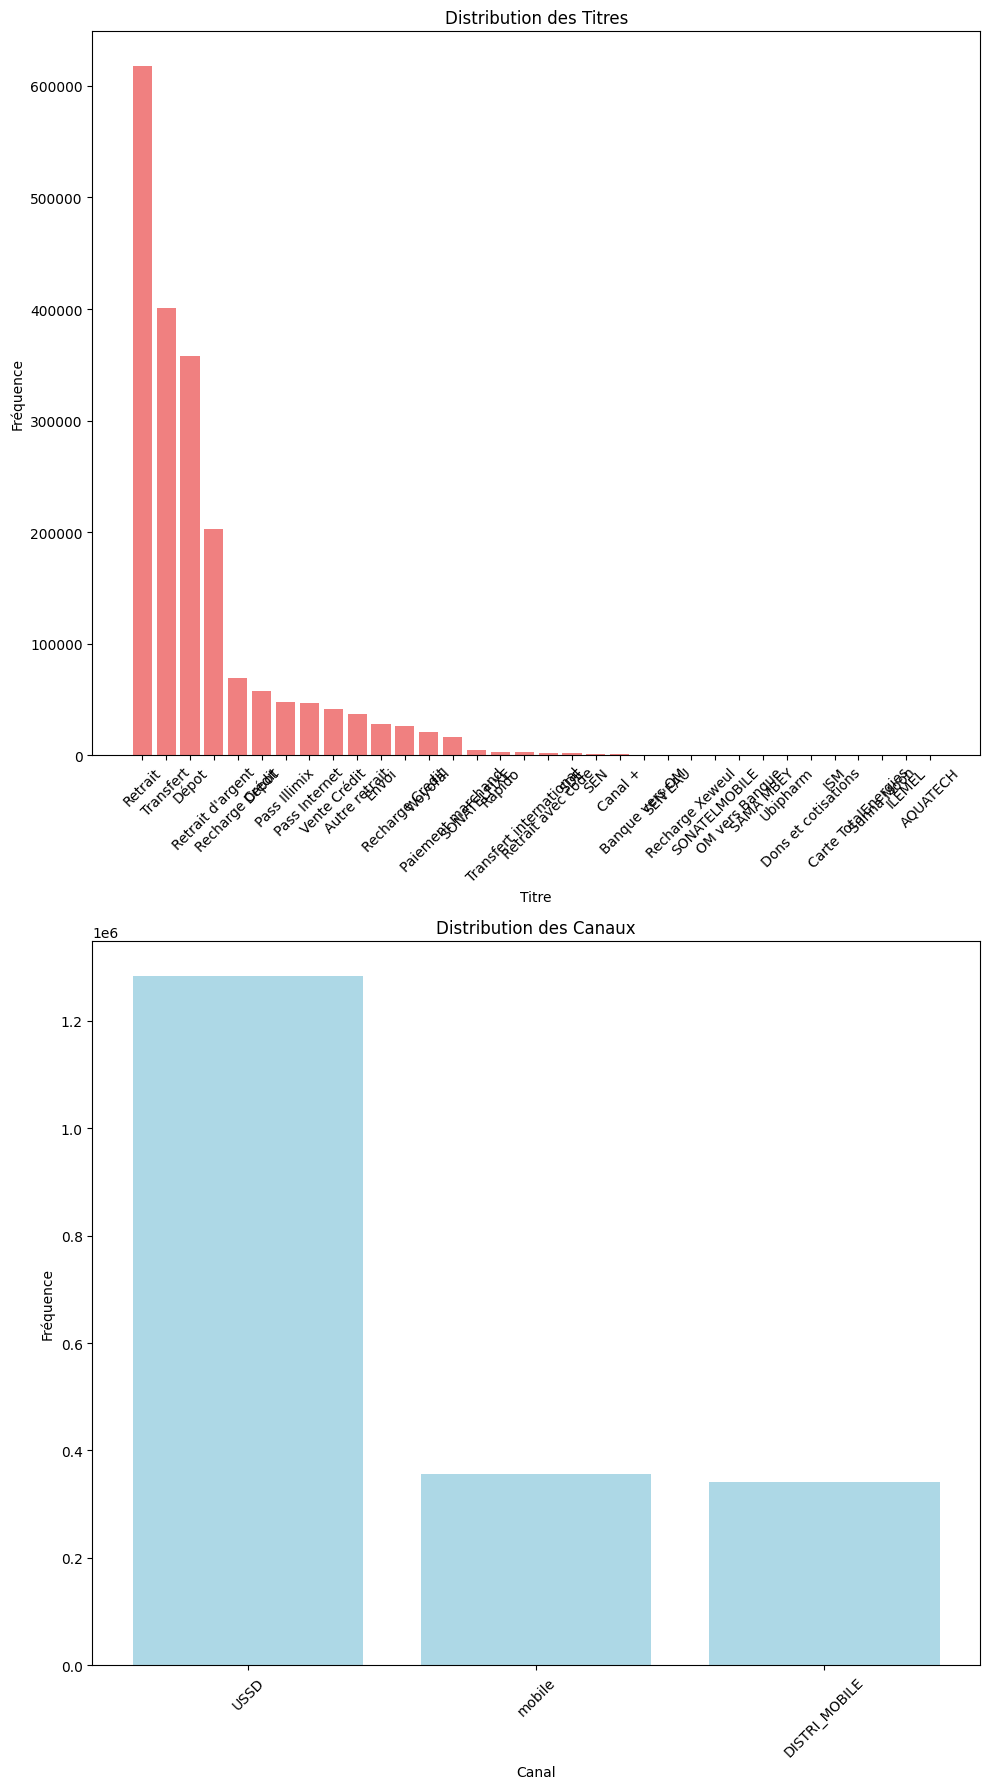

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Supposons que vous ayez un DataFrame Pandas 'pd_transaction_om' avec les données
pd_transaction_om=pd_transaction_om
# Créez une figure avec des sous-graphiques
fig, axes = plt.subplots(2, 1, figsize=(10, 18))


# Sous-graphique 1 : Distribution des Titres
titre_counts = pd_transaction_om['Titre'].value_counts()
axes[0].bar(titre_counts.index, titre_counts.values, color='lightcoral')
axes[0].set_title('Distribution des Titres')
axes[0].set_xlabel('Titre')
axes[0].set_ylabel('Fréquence')
axes[0].tick_params(axis='x', rotation=45)

# Sous-graphique 2 : Distribution des Canaux
channel_counts = pd_transaction_om['Channel'].value_counts()
axes[1].bar(channel_counts.index, channel_counts.values, color='lightblue')
axes[1].set_title('Distribution des Canaux')
axes[1].set_xlabel('Canal')
axes[1].set_ylabel('Fréquence')
axes[1].tick_params(axis='x', rotation=45)


# # Sous-graphique 1 : Distribution des Montants (Intervalles de 10,000)
# montants = pd_transaction_om['Montant'].astype(float)
# bins = range(0, int(montants.max()) + 10000, 10000)
# hist, edges = np.histogram(montants, bins=bins)
# axes[2].hist(montants, bins=bins, color='skyblue', edgecolor='black')
# axes[2].set_xticks(edges)
# axes[2].set_xticklabels([f'{edges[i]:,.0f}-{edges[i+1]:,.0f}' for i in range(len(edges) - 1)])
# axes[2].set_title('Distribution des Montants (Intervalles de 10,000)')
# axes[2].set_xlabel('Montant')
# axes[2].set_ylabel('Fréquence')


# Ajustez l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichez les sous-graphiques
plt.show()


# **MODÉLISATION**

---



## **Méthode RFM**

### Feature engineering

In [96]:
df_rfm = df_transaction_om.select("Numero", "Montant", "Date")
df_rfm.show()

+-------+--------+----------+
| Numero| Montant|      Date|
+-------+--------+----------+
|2644236|  2000.0|2022-03-30|
|2611089| 10000.0|2022-03-17|
|1289124| 25000.0|2022-03-11|
|1118440|  1000.0|2022-03-08|
| 320287| 49603.0|2022-03-06|
|2643081|  5000.0|2022-03-11|
|1294671|  2000.0|2022-03-30|
|1283556|  2000.0|2022-03-02|
|1788766|  1500.0|2022-03-20|
| 382309|  2500.0|2022-03-20|
|1543258| 78500.0|2022-03-25|
|1600060|  2800.0|2022-03-22|
|2586073|100000.0|2022-03-14|
| 942778|  2000.0|2022-03-27|
|1265669| 15000.0|2022-03-17|
|2577254|   690.0|2022-03-03|
|2570130|  3000.0|2022-03-09|
|1255004| 20000.0|2022-03-04|
|2555353|   500.0|2022-03-07|
|1324112|147900.0|2022-03-15|
+-------+--------+----------+
only showing top 20 rows



In [97]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

max_date = df_rfm.agg(max("Date")).collect()[0][0]
string_date=f'{max_date.year}/{max_date.month}/{max_date.day}'
latest_date = to_date(lit(string_date), 'yyyy/M/dd')

df_recency = df_rfm.groupBy("Numero").agg(
    datediff(latest_date, max(col("date"))).alias("Recence")
)

# Calculate Frequency (number of transactions)
df_frequency = df_rfm.groupBy("Numero").agg(
    count("*").alias("Frequence")
)

# Calculate Monetary Value (total transaction amount)
df_monetary = df_rfm.groupBy("Numero").agg(
    sum("montant").alias("Montant")
)

# Join the recency, frequency, and monetary DataFrames
df_rfm= df_recency.join(df_frequency, "Numero", "inner").join(df_monetary, "Numero", "inner")

# Show the RFM DataFrame
df_rfm.show()

+-------+-------+---------+--------+
| Numero|Recence|Frequence| Montant|
+-------+-------+---------+--------+
|1000000|    167|        6| 69800.0|
|1000001|     92|        5| 18150.0|
|1000038|    123|        2|  6500.0|
|1000048|      3|        4|105000.0|
|1000054|    448|        1|  7000.0|
| 100008|    179|        8|136100.0|
|1000083|    476|        1|  1000.0|
| 100010|    538|        1|  1000.0|
|1000101|      0|        5| 52060.0|
|1000122|    214|        2| 21000.0|
|1000131|    260|        7| 98418.0|
|1000147|    369|        1|  2000.0|
|1000176|    113|        1|  2100.0|
|1000204|    295|        3|  3500.0|
|1000214|     11|        1| 24800.0|
|1000263|     38|       20|145699.0|
|1000269|     14|        4| 13400.0|
|1000298|      2|        1|  1000.0|
|  10003|    121|        2|  4000.0|
|1000339|      2|        2| 32050.0|
+-------+-------+---------+--------+
only showing top 20 rows



### Calcul des scores

In [98]:
# Calculer les quantiles
quantiles = df_rfm.approxQuantile(["Recence", "Frequence", "Montant"], [0.2, 0.4, 0.6, 0.8], 0.01)

# Définir des expressions conditionnelles pour attribuer les scores
df_rfm = (df_rfm
    .withColumn("R_Score",  when(col("Recence") <= quantiles[0][0], lit(5))
                            .when(col("Recence") <= quantiles[0][1], lit(4))
                            .when(col("Recence") <= quantiles[0][2], lit(3))
                            .when(col("Recence") <= quantiles[0][3], lit(2))
                            .otherwise(lit(1)))
    .withColumn("F_Score", when(col("Frequence") >= quantiles[1][3], lit(5))
                            .when(col("Frequence") >= quantiles[1][2], lit(4))
                            .when(col("Frequence") >= quantiles[1][1], lit(3))
                            .when(col("Frequence") >= quantiles[1][0], lit(2))
                            .otherwise(lit(1)))
    .withColumn("M_Score", when(col("Montant") >= quantiles[2][3], lit(5))
                            .when(col("Montant") >= quantiles[2][2], lit(4))
                            .when(col("Montant") >= quantiles[2][1], lit(3))
                            .when(col("Montant") >= quantiles[2][0], lit(2))
                            .otherwise(lit(1)))
     .withColumn("RFM_Score", concat(col("R_Score").cast(StringType()), col("F_Score").cast(StringType()), col("M_Score").cast(StringType())))
)

df_rfm.show()

+-------+-------+---------+--------+-------+-------+-------+---------+
| Numero|Recence|Frequence| Montant|R_Score|F_Score|M_Score|RFM_Score|
+-------+-------+---------+--------+-------+-------+-------+---------+
|1000000|    167|        6| 69800.0|      3|      5|      5|      355|
|1000001|     92|        5| 18150.0|      3|      4|      3|      343|
|1000038|    123|        2|  6500.0|      3|      3|      2|      332|
|1000048|      3|        4|105000.0|      5|      4|      5|      545|
|1000054|    448|        1|  7000.0|      1|      2|      2|      122|
| 100008|    179|        8|136100.0|      2|      5|      5|      255|
|1000083|    476|        1|  1000.0|      1|      2|      1|      121|
| 100010|    538|        1|  1000.0|      1|      2|      1|      121|
|1000101|      0|        5| 52060.0|      5|      4|      4|      544|
|1000122|    214|        2| 21000.0|      2|      3|      3|      233|
|1000131|    260|        7| 98418.0|      2|      5|      5|      255|
|10001

### Profilage des segments

In [99]:
# segments2 = {
#    "En train de les perdre mais engagés": ["111", "112", "121", "131", "141", "151"],
#    "Sur le Point de Dormir": [
#         "331", "321", "312", "221", "213", "231", "241", "251"
#     ],
#     "Impossible de les perdre, mais en train de les perdre": [
#         "155", "154", "144", "214", "215", "115", "114", "113"
#     ],
# }

segments = {
    'Champion': ['555', '554', '544', '545', '454', '455', '445'],
    'Fidèle': ['543', '444', '435', '355', '354', '345', '344', '335'],
    'Fidèle potentiel': [
        '553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442',
        '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323'
    ],
    'Prometteur': [
        '525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414',
        '415', '315', '314', '313'
    ],
    'À surveiller': ['535', '534', '443', '434', '343', '334', '325', '324'],
    'À risque': [
        '255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224',
        '153', '152', '145', '143', '142', '135', '134', '133', '125', '124'
    ],
    'En sommeil': [
        '332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211'
    ],
    'Perdu': ['111', '112', '121', '131', '141', '151'],
     'Nouveau': ['512', '511', '422', '421', '412', '411', '311'],
}


# Utiliser une expression conditionnelle pour attribuer les segments
df_rfm =  (df_rfm
    .withColumn('Segment',
        when(col('RFM_Score').isin(segments['Champion']), lit('Champion'))
        .when(col('RFM_Score').isin(segments['Fidèle']), lit('Fidèle'))
        .when(col('RFM_Score').isin(segments['Fidèle potentiel']), lit('Fidèle potentiel'))
        .when(col('RFM_Score').isin(segments['Nouveau']), lit('Nouveau'))
        .when(col('RFM_Score').isin(segments['Prometteur']), lit('Prometteur'))
        .when(col('RFM_Score').isin(segments['À surveiller']), lit('À surveiller'))
        # .when(col('RFM_Score').isin(segments['À réactiver']), lit('À réactiver'))
        .when(col('RFM_Score').isin(segments['À risque']), lit('À risque'))
        # .when(col('RFM_Score').isin(segments['A ne pas perdre']), lit('A ne pas perdre'))
        .when(col('RFM_Score').isin(segments['En sommeil']), lit('En sommeil'))
        .when(col('RFM_Score').isin(segments['Perdu']), lit('Perdu'))
        .otherwise(lit('Autre'))
    )
)


#Save to csv
pd_rfm=df_rfm.toPandas()
pd_rfm.to_csv('#datasets_OM/base_transaction_om_rfm.csv', index=False)

# Afficher le DataFrame résultant
pd_rfm.head()


,Numero,Recence,Frequence,Montant,R_Score,F_Score,M_Score,RFM_Score,Segment
0,1000000,167,6,69800.0,3,5,5,355,Fidèle
1,1000001,92,5,18150.0,3,4,3,343,À surveiller
2,1000038,123,2,6500.0,3,3,2,332,En sommeil
3,1000048,3,4,105000.0,5,4,5,545,Champion
4,1000054,448,1,7000.0,1,2,2,122,En sommeil


### Exploration du Dataframe RFM

In [ ]:
print(f'Date la plus récente {latest_date}')

print("La plus grande fréquence")
max_frequency=df_rfm.select(max(df_rfm["Frequence"])).collect()[0][0]
df_rfm.filter(col("Frequence")==max_frequency).show()

Date la plus récente Column<'to_date(2023/8/17, yyyy/M/dd)'>
La plus grande fréquence
+-------+-------+---------+-----------+-------+-------+-------+---------+--------+
| Numero|Recence|Frequence|    Montant|R_Score|F_Score|M_Score|RFM_Score| Segment|
+-------+-------+---------+-----------+-------+-------+-------+---------+--------+
|1024970|      0|     2566|3.3739856E7|      5|      5|      5|      555|Champion|
+-------+-------+---------+-----------+-------+-------+-------+---------+--------+



<Axes: xlabel='RFM_Score', ylabel='count'>

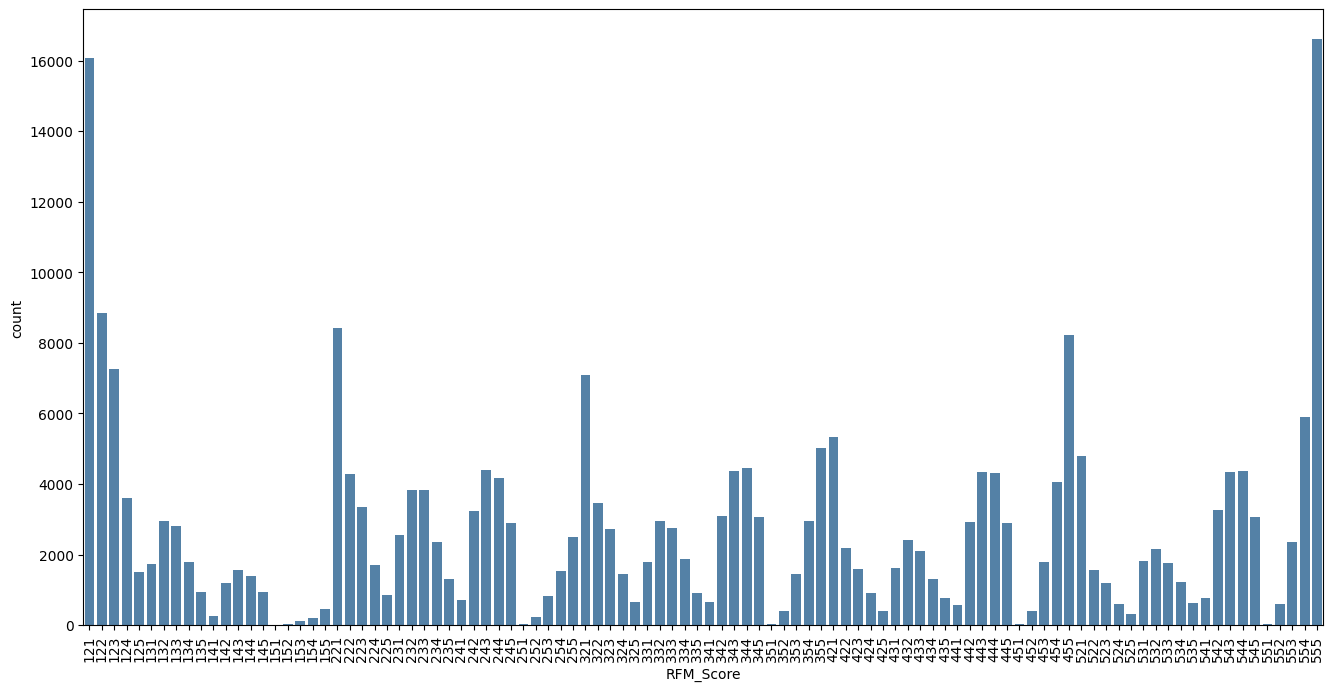

In [ ]:
# Inspect RFM
pd_rfm_sort =pd_rfm.sort_values(["RFM_Score"])

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
plt.xticks(rotation=90)
# sns.histplot(df_rfm_agg_scores["RFMScore"], kde=True, bins=10, ax=ax[0])
sns.countplot(x="RFM_Score", data=pd_rfm_sort,
              color='steelblue')

# sns.histplot(df_rfm_agg_scores["RFMScoreGroup"], color='steelblue', ax=ax[2])

<Axes: xlabel='Montant', ylabel='Count'>

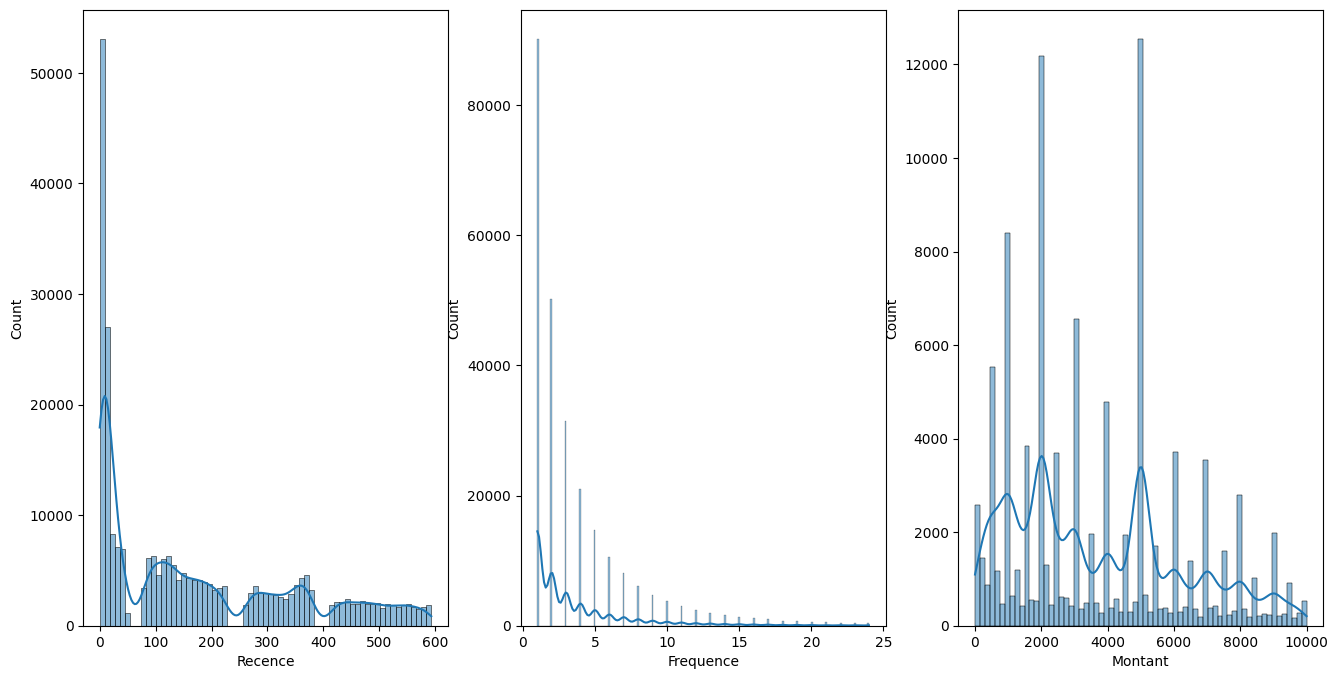

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# Recency distribution plot
sns.histplot(pd_rfm['Recence'], kde=True, ax=ax[0])

# Frequency distribution plot
sns.histplot(pd_rfm.query('Frequence < 25')['Frequence'], kde=True, ax=ax[1])

# Monetary distribution plot
sns.histplot(pd_rfm.query('Montant < 10000')['Montant'], kde=True, ax=ax[2])

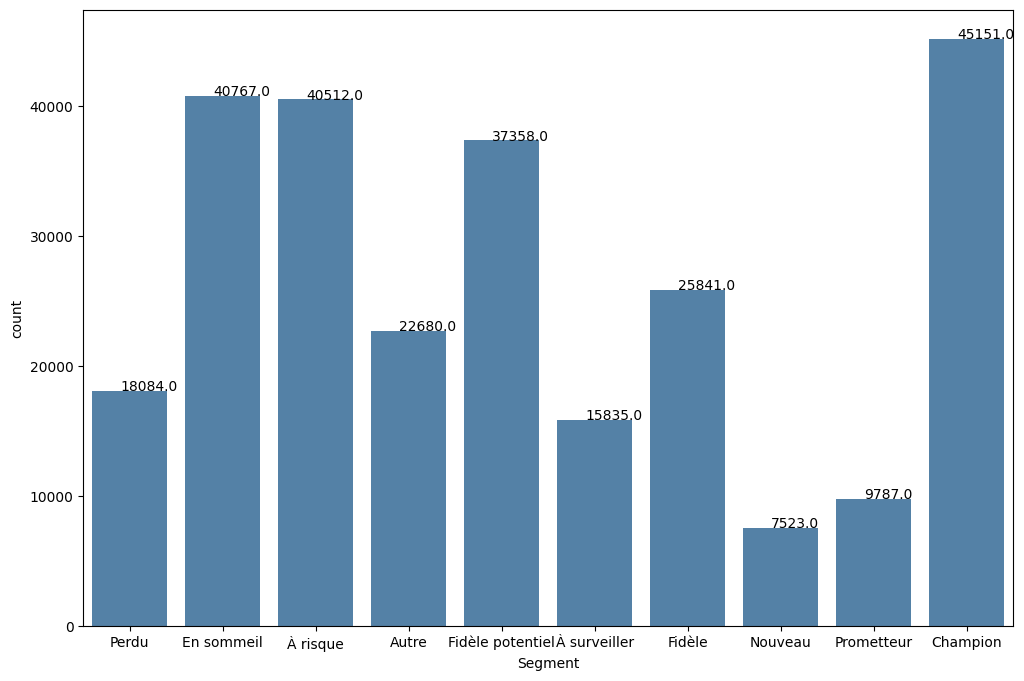

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# sns.histplot(df_rfm_fidelite["Fidelite"], color='steelblue', shrink=.8)
sns.countplot(x="Segment", data=pd_rfm_sort, color='steelblue')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 1))

<Axes: xlabel='Montant', ylabel='Frequence'>

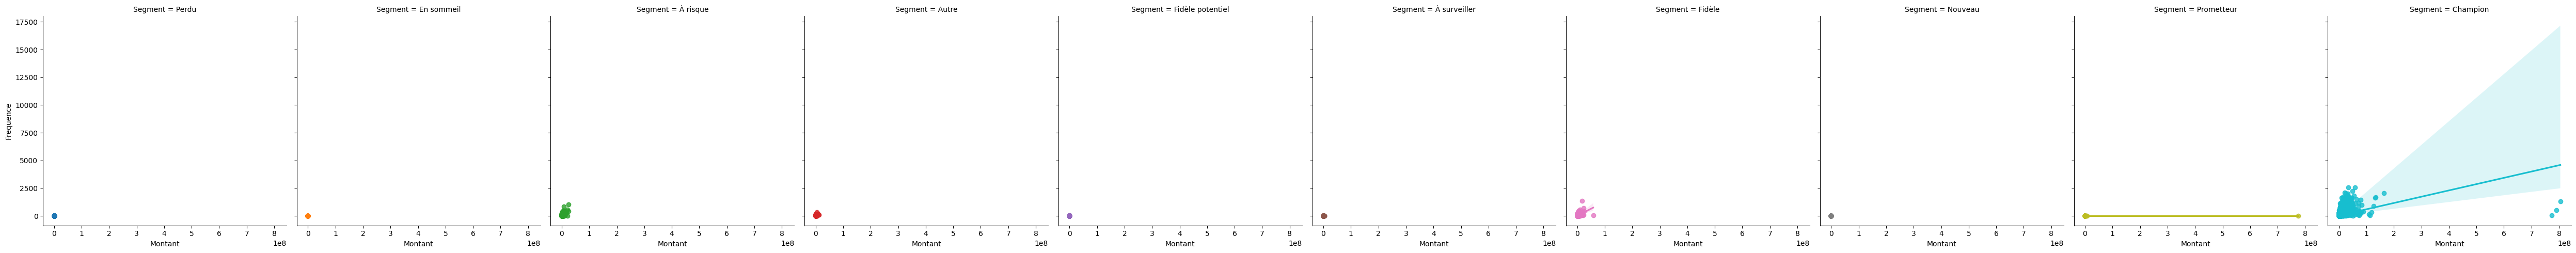

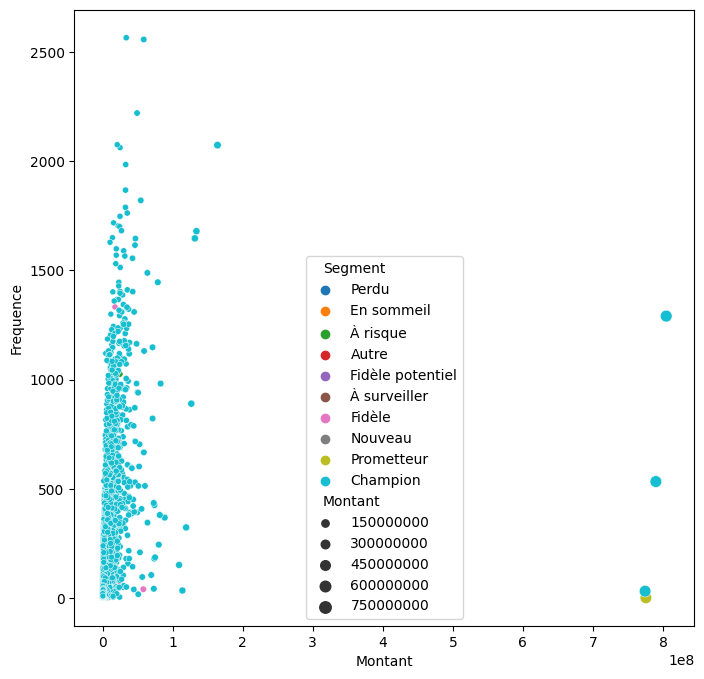

In [ ]:
# Monetary vs Frequency for each segment
sns.lmplot(x='Montant', y='Frequence', data=pd_rfm_sort, col='Segment', hue='Segment', fit_reg=True)

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Montant', y='Frequence', data=pd_rfm_sort, hue='Segment', size='Montant')

<Axes: xlabel='Recence', ylabel='Montant'>

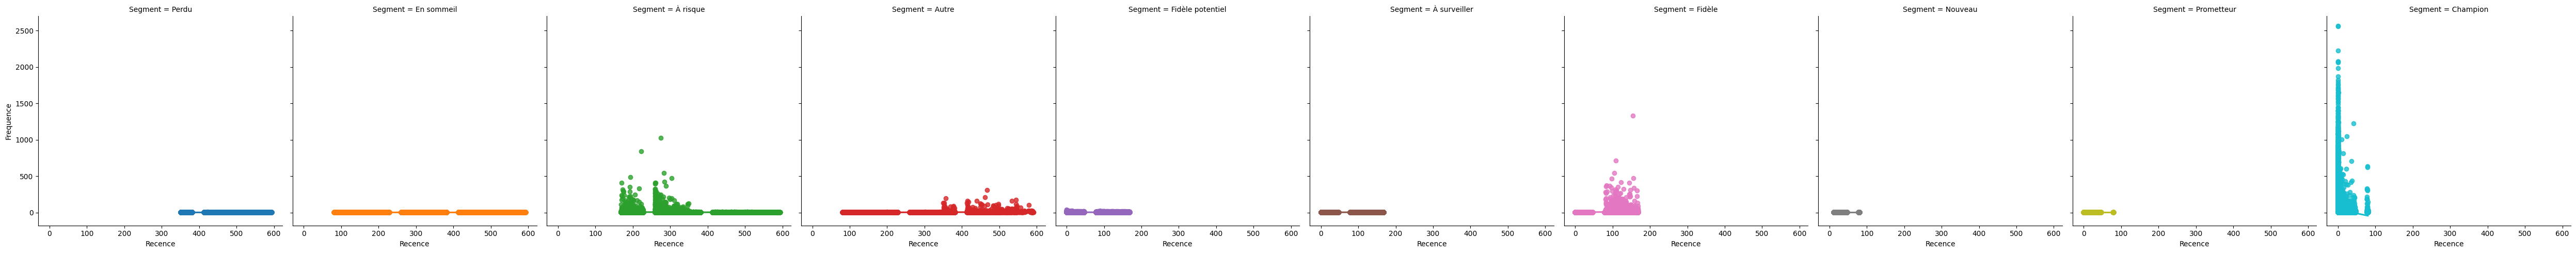

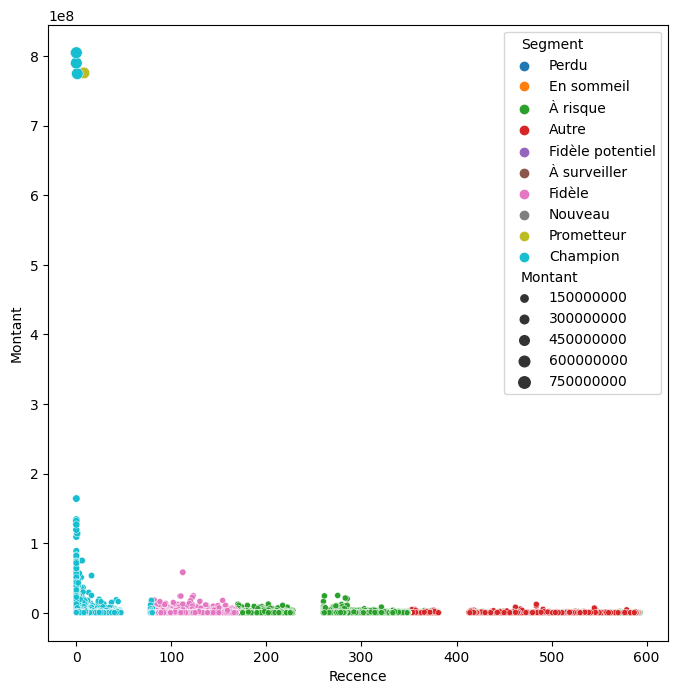

In [ ]:
# Recency vs Frequency for each segment
sns.lmplot(x='Recence', y='Frequence', data=pd_rfm_sort, col='Segment', hue='Segment', fit_reg=True)

# Montant vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recence', y='Montant', data=pd_rfm_sort, hue='Segment', size='Montant')

### Test de la méthode RFM

In [ ]:
def customer_segment(numero):
  segment=df_rfm.select("Numero","Segment").where(col("Numero")==numero).collect()[0][1]
  rfm_result={ "Client":numero,
       "Segment": segment}
  return rfm_result

customer_segment(1000038)

{'Client': 1000038, 'Segment': 'En sommeil'}

## **Méthode K-Means**

---





### Feature engineering

In [34]:
pd_kmeans=pd_transaction_om
df_kmeans=df_transaction_om
df_kmeans.printSchema()
df_kmeans.show(5)
print(f'\n \n Les données manquantes \n{pd_kmeans.isna().sum()}')

root
 |-- Numero: string (nullable = true)
 |-- Montant: float (nullable = true)
 |-- Date: date (nullable = true)
 |-- TypeTransaction: string (nullable = true)
 |-- TitreTransaction: string (nullable = true)
 |-- Channel: string (nullable = true)

+-------+-------+----------+-------------------+----------------+-------+
| Numero|Montant|      Date|    TypeTransaction|TitreTransaction|Channel|
+-------+-------+----------+-------------------+----------------+-------+
|2644236| 2000.0|2022-03-30|             cashin|           Depot|   USSD|
|2611089|10000.0|2022-03-17|    cashout_confirm|         Retrait|   USSD|
|1289124|25000.0|2022-03-11|    cashout_confirm|         Retrait|   USSD|
|1118440| 1000.0|2022-03-08|transfert_sans_code|       Transfert| mobile|
| 320287|49603.0|2022-03-06|        cashinother|   Autre retrait|   USSD|
+-------+-------+----------+-------------------+----------------+-------+
only showing top 5 rows


 
 Les données manquantes 
Numero              0
Montant  

In [40]:
max_date = df_kmeans.agg(max("Date")).collect()[0][0]
string_date=f'{max_date.year}/{max_date.month}/{max_date.day}'
latest_date = to_date(lit(string_date), 'yyyy/M/dd')
latest_date

Column<'to_date(2023/8/17, yyyy/M/dd)'>

In [35]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline


# Define categorical columns to encode
categorical_columns = ["TypeTransaction", "TitreTransaction", "Channel"]

# Initialize stages for the pipeline
stages = []

# Apply StringIndexer for Label Encoding
for col in categorical_columns:
    indexer = StringIndexer(inputCol=col, outputCol=col + "Index")
    stages.append(indexer)

# Create a pipeline
pipeline = Pipeline(stages=stages)

# Fit and transform the DataFrame using the pipeline
model = pipeline.fit(df_kmeans)
transformed_df = model.transform(df_kmeans)

# Show the resulting DataFrame with encoded columns
df_kmeans=transformed_df.select("Numero", "Date", "Montant","TitreTransactionIndex","ChannelIndex" )
df_kmeans.show()

+-------+----------+--------+---------------------+------------+
| Numero|      Date| Montant|TitreTransactionIndex|ChannelIndex|
+-------+----------+--------+---------------------+------------+
|2644236|2022-03-30|  2000.0|                  1.0|         0.0|
|2611089|2022-03-17| 10000.0|                  0.0|         0.0|
|1289124|2022-03-11| 25000.0|                  0.0|         0.0|
|1118440|2022-03-08|  1000.0|                  2.0|         1.0|
| 320287|2022-03-06| 49603.0|                  7.0|         0.0|
|2643081|2022-03-11|  5000.0|                  2.0|         0.0|
|1294671|2022-03-30|  2000.0|                  0.0|         0.0|
|1283556|2022-03-02|  2000.0|                  1.0|         0.0|
|1788766|2022-03-20|  1500.0|                  2.0|         1.0|
| 382309|2022-03-20|  2500.0|                  2.0|         0.0|
|1543258|2022-03-25| 78500.0|                  2.0|         0.0|
|1600060|2022-03-22|  2800.0|                  0.0|         2.0|
|2586073|2022-03-14|10000

In [36]:
df_kmeans.printSchema()

root
 |-- Numero: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Montant: float (nullable = true)
 |-- TitreTransactionIndex: double (nullable = false)
 |-- ChannelIndex: double (nullable = false)



### Nombre de clusters

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
# Define the feature columns for clustering
feature_columns = ["Montant", "Date", "TitreTransactionIndex", "ChannelIndex"]

# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_kmeans = assembler.transform(df_kmeans)

# Try different values of k and evaluate their cost
cost = []
for k in range(2, 11):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans)
    cost.append(model.summary.trainingCost)


plt.plot(range(2, 11), cost, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()


### Modèle

In [ ]:
# Choose the optimal number of clusters (e.g., 4)
optimal_k = 4

kmeans = KMeans().setK(optimal_k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)

# Get the cluster assignments for each data point
clustered_df = model.transform(df_kmeans)

# Rename the "prediction" column to "Cluster"
clustered_df = clustered_df.withColumnRenamed("prediction", "Cluster")

# Show the DataFrame with the "Cluster" column
clustered_df.show()

+-------+--------+---------------------+------------+------------------+-------+
| Numero| Montant|TitreTransactionIndex|ChannelIndex|          features|Cluster|
+-------+--------+---------------------+------------+------------------+-------+
|2644236|  2000.0|                  1.0|         0.0|  [2000.0,1.0,0.0]|      0|
|2611089| 10000.0|                  0.0|         0.0| [10000.0,0.0,0.0]|      0|
|1289124| 25000.0|                  0.0|         0.0| [25000.0,0.0,0.0]|      0|
|1118440|  1000.0|                  2.0|         1.0|  [1000.0,2.0,1.0]|      0|
| 320287| 49603.0|                  7.0|         0.0| [49603.0,7.0,0.0]|      0|
|2643081|  5000.0|                  2.0|         0.0|  [5000.0,2.0,0.0]|      0|
|1294671|  2000.0|                  0.0|         0.0|  [2000.0,0.0,0.0]|      0|
|1283556|  2000.0|                  1.0|         0.0|  [2000.0,1.0,0.0]|      0|
|1788766|  1500.0|                  2.0|         1.0|  [1500.0,2.0,1.0]|      0|
| 382309|  2500.0|          

In [ ]:
clustered_df=clustered_df.drop("features")
clustered_df.show()

+-------+--------+---------------------+------------+-------+
| Numero| Montant|TitreTransactionIndex|ChannelIndex|Cluster|
+-------+--------+---------------------+------------+-------+
|2644236|  2000.0|                  1.0|         0.0|      0|
|2611089| 10000.0|                  0.0|         0.0|      0|
|1289124| 25000.0|                  0.0|         0.0|      0|
|1118440|  1000.0|                  2.0|         1.0|      0|
| 320287| 49603.0|                  7.0|         0.0|      0|
|2643081|  5000.0|                  2.0|         0.0|      0|
|1294671|  2000.0|                  0.0|         0.0|      0|
|1283556|  2000.0|                  1.0|         0.0|      0|
|1788766|  1500.0|                  2.0|         1.0|      0|
| 382309|  2500.0|                  2.0|         0.0|      0|
|1543258| 78500.0|                  2.0|         0.0|      0|
|1600060|  2800.0|                  0.0|         2.0|      0|
|2586073|100000.0|                  7.0|         0.0|      0|
| 942778

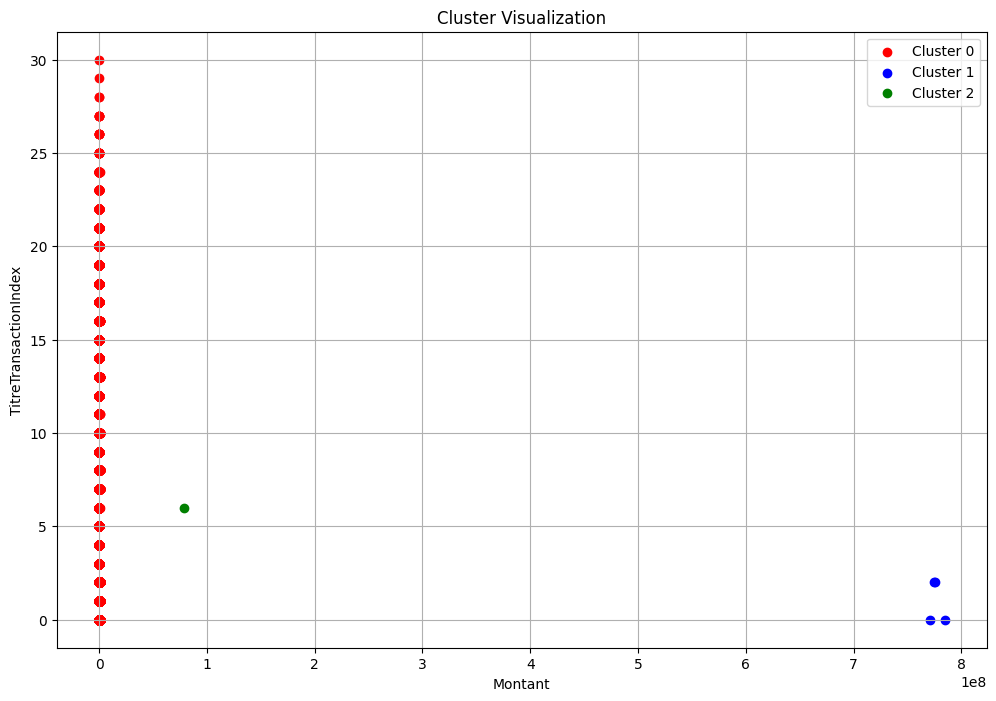

In [26]:


# Assuming 'clustered_df' contains the cluster assignments
# Extract the relevant columns for visualization
clustered_data = clustered_df.select("Montant", "TitreTransactionIndex", "ChannelIndex", "Cluster")

# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_df = clustered_data.toPandas()

# Create scatter plots for different pairs of features
plt.figure(figsize=(12, 8))

# Example: Montant vs. TitreTransactionIndex
plt.scatter(pandas_df[pandas_df['Cluster'] == 0]['Montant'], pandas_df[pandas_df['Cluster'] == 0]['TitreTransactionIndex'], c='red', label='Cluster 0')
plt.scatter(pandas_df[pandas_df['Cluster'] == 1]['Montant'], pandas_df[pandas_df['Cluster'] == 1]['TitreTransactionIndex'], c='blue', label='Cluster 1')
plt.scatter(pandas_df[pandas_df['Cluster'] == 2]['Montant'], pandas_df[pandas_df['Cluster'] == 2]['TitreTransactionIndex'], c='green', label='Cluster 2')
# Add more clusters as needed

# Customize the plot
plt.xlabel('Montant')
plt.ylabel('TitreTransactionIndex')
plt.title('Cluster Visualization')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
clustered_df.select("Numero", "Montant", "Cluster").show()

+----------+
|prediction|
+----------+
|         3|
|         5|
|         4|
|         0|
|         1|
|         2|
+----------+



### Visualisation des segments K-Means

,Numero,Montant,Date,TypeTransaction,TitreTransaction,Channel,Cluster
0,2644236,2000.0,2022-03-30,cashin,Depot,USSD,0
1,2611089,10000.0,2022-03-17,cashout_confirm,Retrait,USSD,2
2,1289124,25000.0,2022-03-11,cashout_confirm,Retrait,USSD,2
3,1118440,1000.0,2022-03-08,transfert_sans_code,Transfert,mobile,0
4,320287,49603.0,2022-03-06,cashinother,Autre retrait,USSD,0
...,...,...,...,...,...,...,...
1991544,1178500,25000.0,2022-08-12,cashout,Retrait,DISTRI_MOBILE,4
1991545,2567456,2200.0,2022-08-23,achat_pass_illimix,Pass Illimix,mobile,0
1991546,2627432,50000.0,2022-08-20,cashout,Retrait,DISTRI_MOBILE,4
1991547,980694,3000.0,2022-08-30,transfert_sans_code,Transfert,mobile,0


### Profilage des segments

In [ ]:
# rfm_k=spark.createDataFrame()
# rfm_k =  (rfm_k
#     .withColumn('Segment',
#         when(col('Cluster')==0, lit('Very High'))
#         .when(col('Cluster')==1, lit('High'))
#         .when(col('Cluster')==2, lit('Medium'))
#          .when(col('Cluster')==3, lit('Low'))
#         .otherwise(lit('Autre'))
#     )
# )

# printdf(rfm_k.filter(col("Segment")=="Medium"))

## **Méthode CLTV**
<center>
<div class="alert alert-block alert-info">
<b>Quelle est la CLTV (valeur à vie du client - Customer LifeTime) ?</b> </div></center>

La valeur à vie du client (CLTV) est une prédiction du bénéfice net attribué à l'ensemble de la relation future avec un client. Il estime la valeur totale qu'une entreprise tirera d'une relation client, en tenant compte des revenus, des coûts et des modèles de comportement des clients sur une période de temps définie. CLTV aide les entreprises à comprendre la valeur de l'acquisition et de la fidélisation des clients, et à orienter les décisions d'investissement dans les initiatives de gestion de la relation client.


<center>
<div class="alert alert-block alert-info">
<b>À propos du processus de cette section</b> </div></center>

Je vais appliquerdeux modèles: BetaGeoFitter et GammaGammaFitter. Je vais utiliser le modèle BetaGeoFilter pour prédire la fréquence à laquelle le client achète. Je vais utiliser le modèle GammaGammaFilter pour prédire le profit qu'un client apportera. Et puis je vais analyser les données.

In [141]:
today_date = dt.datetime(2023, 8, 19)
pd_transaction_om['Date'] = pd.to_datetime(pd_transaction_om['Date'])
# Create the df_cltv dataframe.
df_clt = pd_transaction_om.groupby("Numero").agg({"Date" : [lambda Date: (Date.max() - Date.min()).days, # recency
                                                  lambda Date: (today_date - Date.min()).days], # T
                                         "Numero" : lambda Numero:Numero.nunique(), # frequnecy
                                         "Montant": lambda Montant: Montant.sum()}) # monatery

In [142]:
# I specfy the column name of df_cltv
df_clt.columns = ["Recence", "T", "Frequence", "Montant"]
# I remove the column names of df_cltv because I am going to change them.
# df_clt.columns = df_clt.columns.droplevel(0)
# I specfy the column name of df_cltv
df_clt.head()

,Recence,T,Frequence,Montant
Numero,,,,
17,300,380,1,221200.0
62,99,101,1,9900.0
64,274,366,1,22000.0
70,0,360,1,42000.0
77,0,4,1,100.0


### Calculating and subtracting outlier values from the data <a id = "4a"></a>
In this chapter, I am going to calculate and subtract outlier values from the data

At the code blocks below, I am going to calculate the outlier with outlier_thresholds and then subtract it with replace_with_threshold.

In [143]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return up_limit, low_limit

def replace_with_threshold(dataframe, variable):
    up_limit, low_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

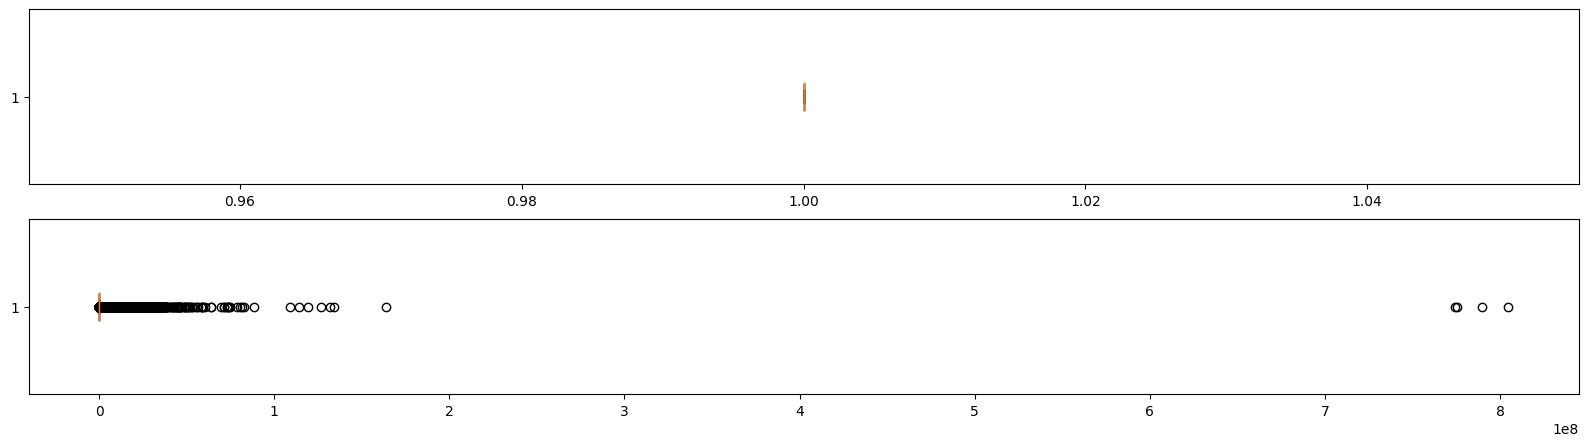

In [144]:
# I observe them before removing outliers.
f, ax = plt.subplots(2,1, figsize = (20,5))
col_list = ["Frequence", "Montant"]
for i in range(0,2):
    ax[i].boxplot(df_clt[col_list[i]], vert = 0)
plt.show()

In [145]:
# I apply the functions for remove the outlier.
replace_with_threshold(df_clt, "Frequence")
replace_with_threshold(df_clt, "Montant")

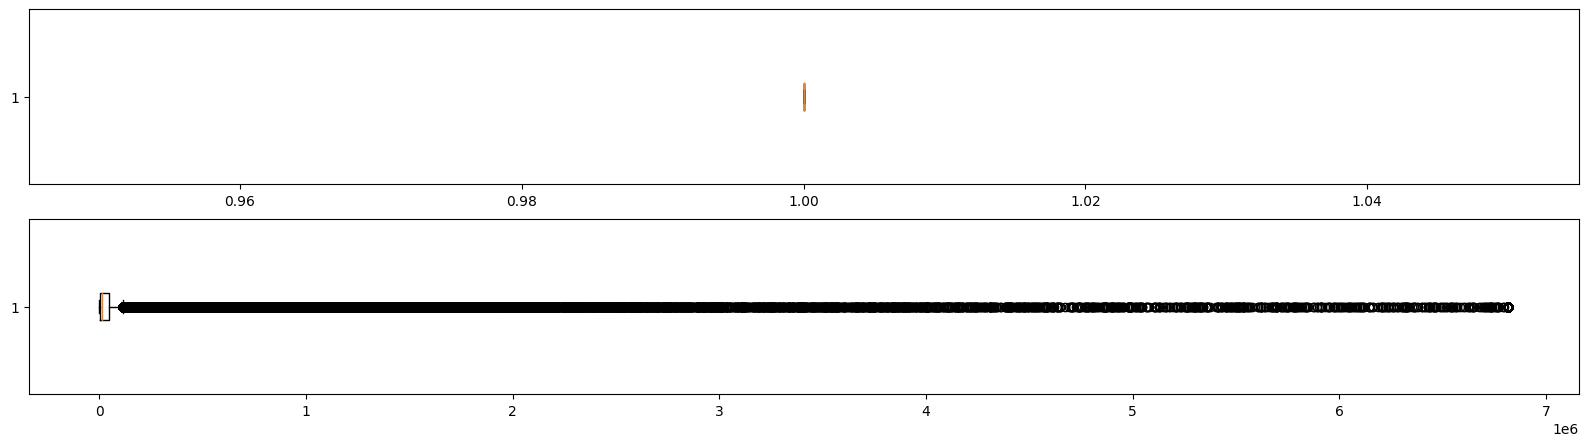

In [146]:
# I observe them after removing outliers.
f, ax = plt.subplots(2,1, figsize = (20,5))
for i in range(0,2):
    ax[i].boxplot(df_clt[col_list[i]], vert = 0)
plt.show()

In [147]:
df_clt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263538 entries, 17 to 2646662
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Recence    263538 non-null  int64  
 1   T          263538 non-null  int64  
 2   Frequence  263538 non-null  int64  
 3   Montant    263538 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 10.1 MB


### BG-NBD <a id= "4c"></a>
In this section, I will apply the BetaGeoFitter model to the df_clt I created.

In [ ]:
# Model
bgf = BetaGeoFitter()

# fit with frequency, recency, and T values.
bgf.fit(df_clt["Frequence"],
       df_clt["Recence"],
       df_clt["T"])

At the code block below, I calculate how often shop customers in one month with the BetaGeoFitter model.

In [ ]:
# Calculating one monthly values
bgf.predict(4,
           df_clt["Frequence"],
           df_clt["Recence"],
           df_clt["Montant"]).sort_values(ascending = False).head(10)

In [ ]:
# Calculating three monthly values
bgf.predict(4*3,
           df_clt["Frequence"],
           df_clt["Recence"],
           df_clt["Montant"]).sort_values(ascending = False).head(10)

In [ ]:
# Adding the three monthly values to the df_clt
df_clt["expected_purc_3_month"] = bgf.predict(4*3,
                                               df_clt["Frequence"],
                                               df_clt["Recence"],
                                               df_clt["Montant"])

In [ ]:
df_clt.head()

In [ ]:
# Calculating six monthly values
bgf.predict(4*6,
           df_clt["Frequence"],
           df_clt["Recence"],
           df_clt["Montant"]).sort_values(ascending = False).head(10)

In [ ]:
# Adding the six monthly values to the df_clt
df_clt["expected_purc_6_month"] = bgf.predict(4*6,
                                               df_clt["Frequence"],
                                               df_clt["Recence"],
                                               df_clt["Montant"])

In [ ]:
df_clt.head()

### Gamma Gamma <a id="4d"></a>
In this section, I will apply the GammaGammaFitter model to the df_clt I created.

In [130]:
# Model
ggf = GammaGammaFitter(penalizer_coef = 0.01)

# fitting with frequency adn monetary values
ggf.fit(df_clt["Frequence"], df_clt["Montant"])

<lifetimes.GammaGammaFitter: fitted with 263538 subjects, p: 2.76, q: 0.13, v: 2.55>

At the code block below, I calculate how much profit a customer will bring in with the gammagammafitter model.

In [131]:
ggf.conditional_expected_average_profit(df_clt["Frequence"], df_clt["Montant"]).sort_values(ascending = False).head(10)

Numero
614084     1.172341e+09
432517     1.150792e+09
524990     1.130033e+09
129011     1.128427e+09
176177     2.390020e+08
1089547    1.951962e+08
1377467    1.919110e+08
2617447    1.845653e+08
397533     1.737602e+08
1712881    1.660864e+08
dtype: float64

In [132]:
# Adding the prediction values to df_rfm.
df_clt["expected_average_profit"] = ggf.conditional_expected_average_profit(df_clt["Frequence"], df_clt["Montant"])

In [133]:
df_clt.head()

,Recence,T,Frequence,Montant,expected_average_profit
Numero,,,,,
17,300,380,1,221200.0,322312.080894
62,99,101,1,9900.0,14428.909280
64,274,366,1,22000.0,32059.701407
70,0,360,1,42000.0,61201.506577
77,0,4,1,100.0,149.424747


At the code block below, I calculate the cltv values of the customer.

In [134]:
cltv = ggf.customer_lifetime_value(bgf,
                                  df_clt["Frequence"],
                                  df_clt["Recence"],
                                  df_clt["Montant"],
                                  df_clt["Montant"],
                                  time = 6, # six mounth
                                  freq = "W",
                                  discount_rate = 0.01)

AttributeError: ignored

In [ ]:
cltv.head(10)

In [ ]:
# Adding the cltv values to the df_clt.
df_clt["cltv"] = cltv

In [ ]:
df_clt.head()

### Segmentation <a id = "4e"></a>
In this chapter, I split the cltv values into segments.

In [ ]:
df_clt["segment"] = pd.qcut(df_clt["cltv"], 4, labels = ["D", "C", "B", "A"])

In [ ]:
df_clt.head()

### Review The CLTV DataFrame <a id="4f"></a>
In this chapter, I am going to review the df_clt.

In [ ]:
df_clt.head()

At the code below, I check count, mean, and sum value of segments on the other values.

In [ ]:
df_clt.groupby("segment").agg({"count", "mean", "sum"})

In [ ]:
df_clt.sort_values(by = "Recence", ascending = False).head()

In [ ]:
def check_cltv_best_and_worst(column):
    print(f"############ Top five - {column} ############")
    print(df_clt.sort_values(by = column, ascending = False).head())
    print(f"############ Bottom five - {column} ############")
    print(df_clt.sort_values(by = column, ascending = True).head())

In [ ]:
check_cltv_best_and_worst("Recence")

In [ ]:
check_cltv_best_and_worst("Frequence")

In [ ]:
check_cltv_best_and_worst("Montant")

In [ ]:
df_clt.head()

In [ ]:
# Correlation between the columns.
df_clt.corr()

At the code block below, I visualize the correlation between the df_clt columns.

In [ ]:
# Visualization of correlation result with seaborn library heatmap.
f, ax = plt.subplots(figsize = (10,10))
sns.heatmap(df_clt.corr(), annot = True, linewidths=0.5, linecolor = "black", fmt = ".4f", ax = ax)
plt.show()

At the code block below, I visualize the distributions of the segments in the df_clt datafrem.

In [ ]:
# Visualization of correlation results with seaborn library pairplot
sns.pairplot(df_clt, hue = "segment")

## **Hierarchical Clustering**

---



## **DBSCAN**

# **TESTS**

In [ ]:
# #Importation des CSV
# path='/content/drive/MyDrive/Colab/Segmentation/#datasets_OM'
# file_list=['2022_2.csv', '2022_3.csv','2022_4.csv','2022_5.csv','2022_6.csv','2022_7.csv',  '2022_8.csv', '2022_8.csv','2022_9.csv','2022_10.csv','2022_11.csv','2022_12.csv','2023_1.csv','2023_2.csv','2023_3.csv','2023_4.csv','2023_5.csv','2023_6.csv','2023_7.csv', ]
# df_agg = spark.read.csv(f'{path}/2022_1.csv', header=True)
# for csv_file in file_list:
#   df = spark.read.csv(f'{path}/{csv_file}', header=True, inferSchema=True)
#   df_agg = df_agg.union(df)

# df_agg.write.csv('#datasets_OM/trusted_om.base_transaction.csv', header=True, mode='overwrite')
# # df_agg.toPandas().to_csv('#datasets_OM/trusted_om.transactions.csv', index=False)
# # Show the RFM DataFrame
# df_agg.show()

In [ ]:
DF=df_agg.toPandas()
DF.info()

In [ ]:
#!git clone https://github.com/asish012/dataanalytics.git